In [1]:
!pip install pydicom

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import warnings
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydicom as dcm
import os

import random
import math
import cv2  # OpenCV for image processing
import tensorflow as tf

from tqdm.notebook import tqdm
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Layer, Convolution2D, Dense, RandomRotation, RandomFlip, Resizing, Rescaling
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Input, ReLU, AveragePooling2D, Activation, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras import losses, optimizers
from keras import backend as K
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from matplotlib.patches import Rectangle
from zipfile import ZipFile
from collections import defaultdict
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
# Import required libraries


_path = 'stage_2_train_images/'

## Step 1: Import the data.

In [3]:
df1 = pd.read_csv("stage_2_detailed_class_info.csv")
df1.head()

patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity

In [4]:
df1.shape

(30227, 2)

In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  30227 non-null  object
 1   class      30227 non-null  object
dtypes: object(2)
memory usage: 472.4+ KB


In [6]:
df1["class"].value_counts()

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64

In [7]:
# Percentage of each class :-
df1["class"].value_counts()/ len(df1)

No Lung Opacity / Not Normal    0.391074
Lung Opacity                    0.316108
Normal                          0.292818
Name: class, dtype: float64

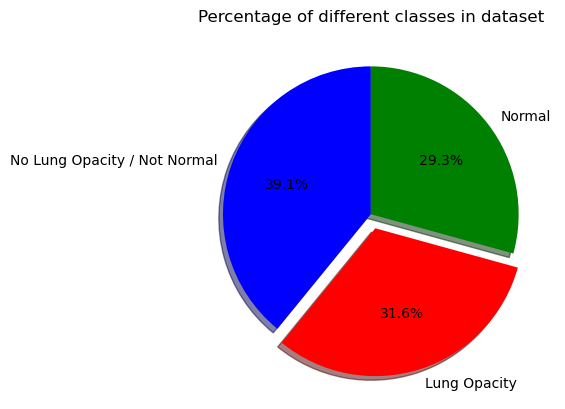

In [8]:
data_size = df1['class'].value_counts()
colors = ['blue','red','green']
labels = 'No Lung Opacity / Not Normal', 'Lung Opacity','Normal'
explode = (0, 0.1, 0)
plt.pie(data_size,explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90,)
plt.title('Percentage of different classes in dataset')
plt.show()

In [9]:
df2 = pd.read_csv("stage_2_sample_submission.csv")
df2.head()

patientId PredictionString
0  0000a175-0e68-4ca4-b1af-167204a7e0bc  0.5 0 0 100 100
1  0005d3cc-3c3f-40b9-93c3-46231c3eb813  0.5 0 0 100 100
2  000686d7-f4fc-448d-97a0-44fa9c5d3aa6  0.5 0 0 100 100
3  000e3a7d-c0ca-4349-bb26-5af2d8993c3d  0.5 0 0 100 100
4  00100a24-854d-423d-a092-edcf6179e061  0.5 0 0 100 100

In [10]:
df3 = pd.read_csv("stage_2_train_labels.csv")
df3.head()

patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1

In [11]:
df3.shape

(30227, 6)

In [12]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


In [13]:
df3 = pd.concat([df1, df3.drop(columns=['patientId'])], axis=1)
df3.head()

patientId                         class      x  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal    NaN   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal    NaN   
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal    NaN   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal    NaN   
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity  264.0   

       y  width  height  Target  
0    NaN    NaN     NaN       0  
1    NaN    NaN     NaN       0  
2    NaN    NaN     NaN       0  
3    NaN    NaN     NaN       0  
4  152.0  213.0   379.0       1

In [14]:
df3.shape # after concatenating with df1

(30227, 7)

In [15]:
df3.info() # after concatenating with df1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   class      30227 non-null  object 
 2   x          9555 non-null   float64
 3   y          9555 non-null   float64
 4   width      9555 non-null   float64
 5   height     9555 non-null   float64
 6   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 1.6+ MB


In [16]:
# Percentage of Null values for df3 after concatenation
null_percentage = (df3.isnull().sum() / len(df3)) * 100
print("Percentage of Null Values in each column:")
print(null_percentage)

Percentage of Null Values in each column:
patientId     0.000000
class         0.000000
x            68.389188
y            68.389188
width        68.389188
height       68.389188
Target        0.000000
dtype: float64


In [17]:
df3["Target"].value_counts()

0    20672
1     9555
Name: Target, dtype: int64

In [18]:
# Percentage of Target :-
df3["Target"].value_counts() / len(df2)

0    6.890667
1    3.185000
Name: Target, dtype: float64

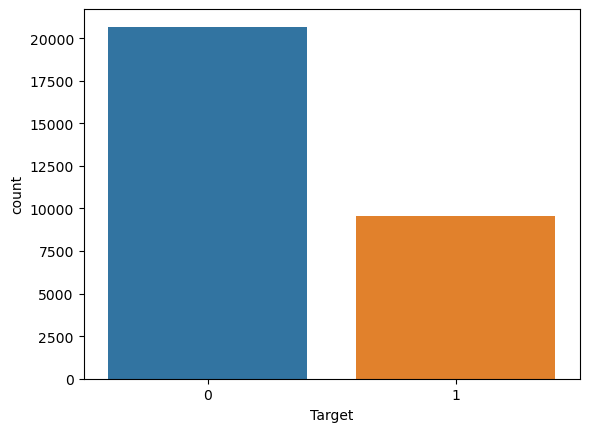

In [19]:
import seaborn as sns
sns.countplot(data = df3, x = 'Target');

In [20]:
df4 = df3.iloc[:800].copy() #Copy limited data to design model faster
df4.shape

(800, 7)

In [21]:
#remove duplicate if any found
#duplicates = df4[df4.duplicated()]
#df4 = duplicates.drop_duplicates()

In [22]:
#Comment this code for full data access
df4['class'].unique()

array(['No Lung Opacity / Not Normal', 'Normal', 'Lung Opacity'],
      dtype=object)

## Step 2: Map training and testing images to its classes.

In [23]:
# Function to load DICOM files and extract pixel data
def load_dicom_images_from_directory(directory):
    dicom_images = []
    for row in df4.iterrows():
        filename = row[1]['patientId']+'.dcm'
        filepath = os.path.join(directory, filename)
        if os.path.isfile(filepath) and filename.endswith(".dcm") and os.path.getsize(filepath) > 0:
            dicom_data = dcm.dcmread(filepath)
            dicom_images.append(dicom_data)
    return dicom_images

# Load DICOM images from the dataset directory
dicom_images = load_dicom_images_from_directory(_path)

# Function to convert DICOM pixel data to a suitable format (e.g., JPEG or PNG)
def dicom_to_image_array(dicom_data, target_size=(244,244)):
    # Rescale the pixel values to 0-255 range (8-bit image)
    img_array = dicom_data.pixel_array
    img_array = cv2.convertScaleAbs(img_array, alpha=(255.0 / np.max(img_array)))

    return img_array

# Process DICOM images and convert them to image arrays
image_arrays = [dicom_to_image_array(dicom_data) for dicom_data in dicom_images]

In [24]:
print(len(image_arrays))

800


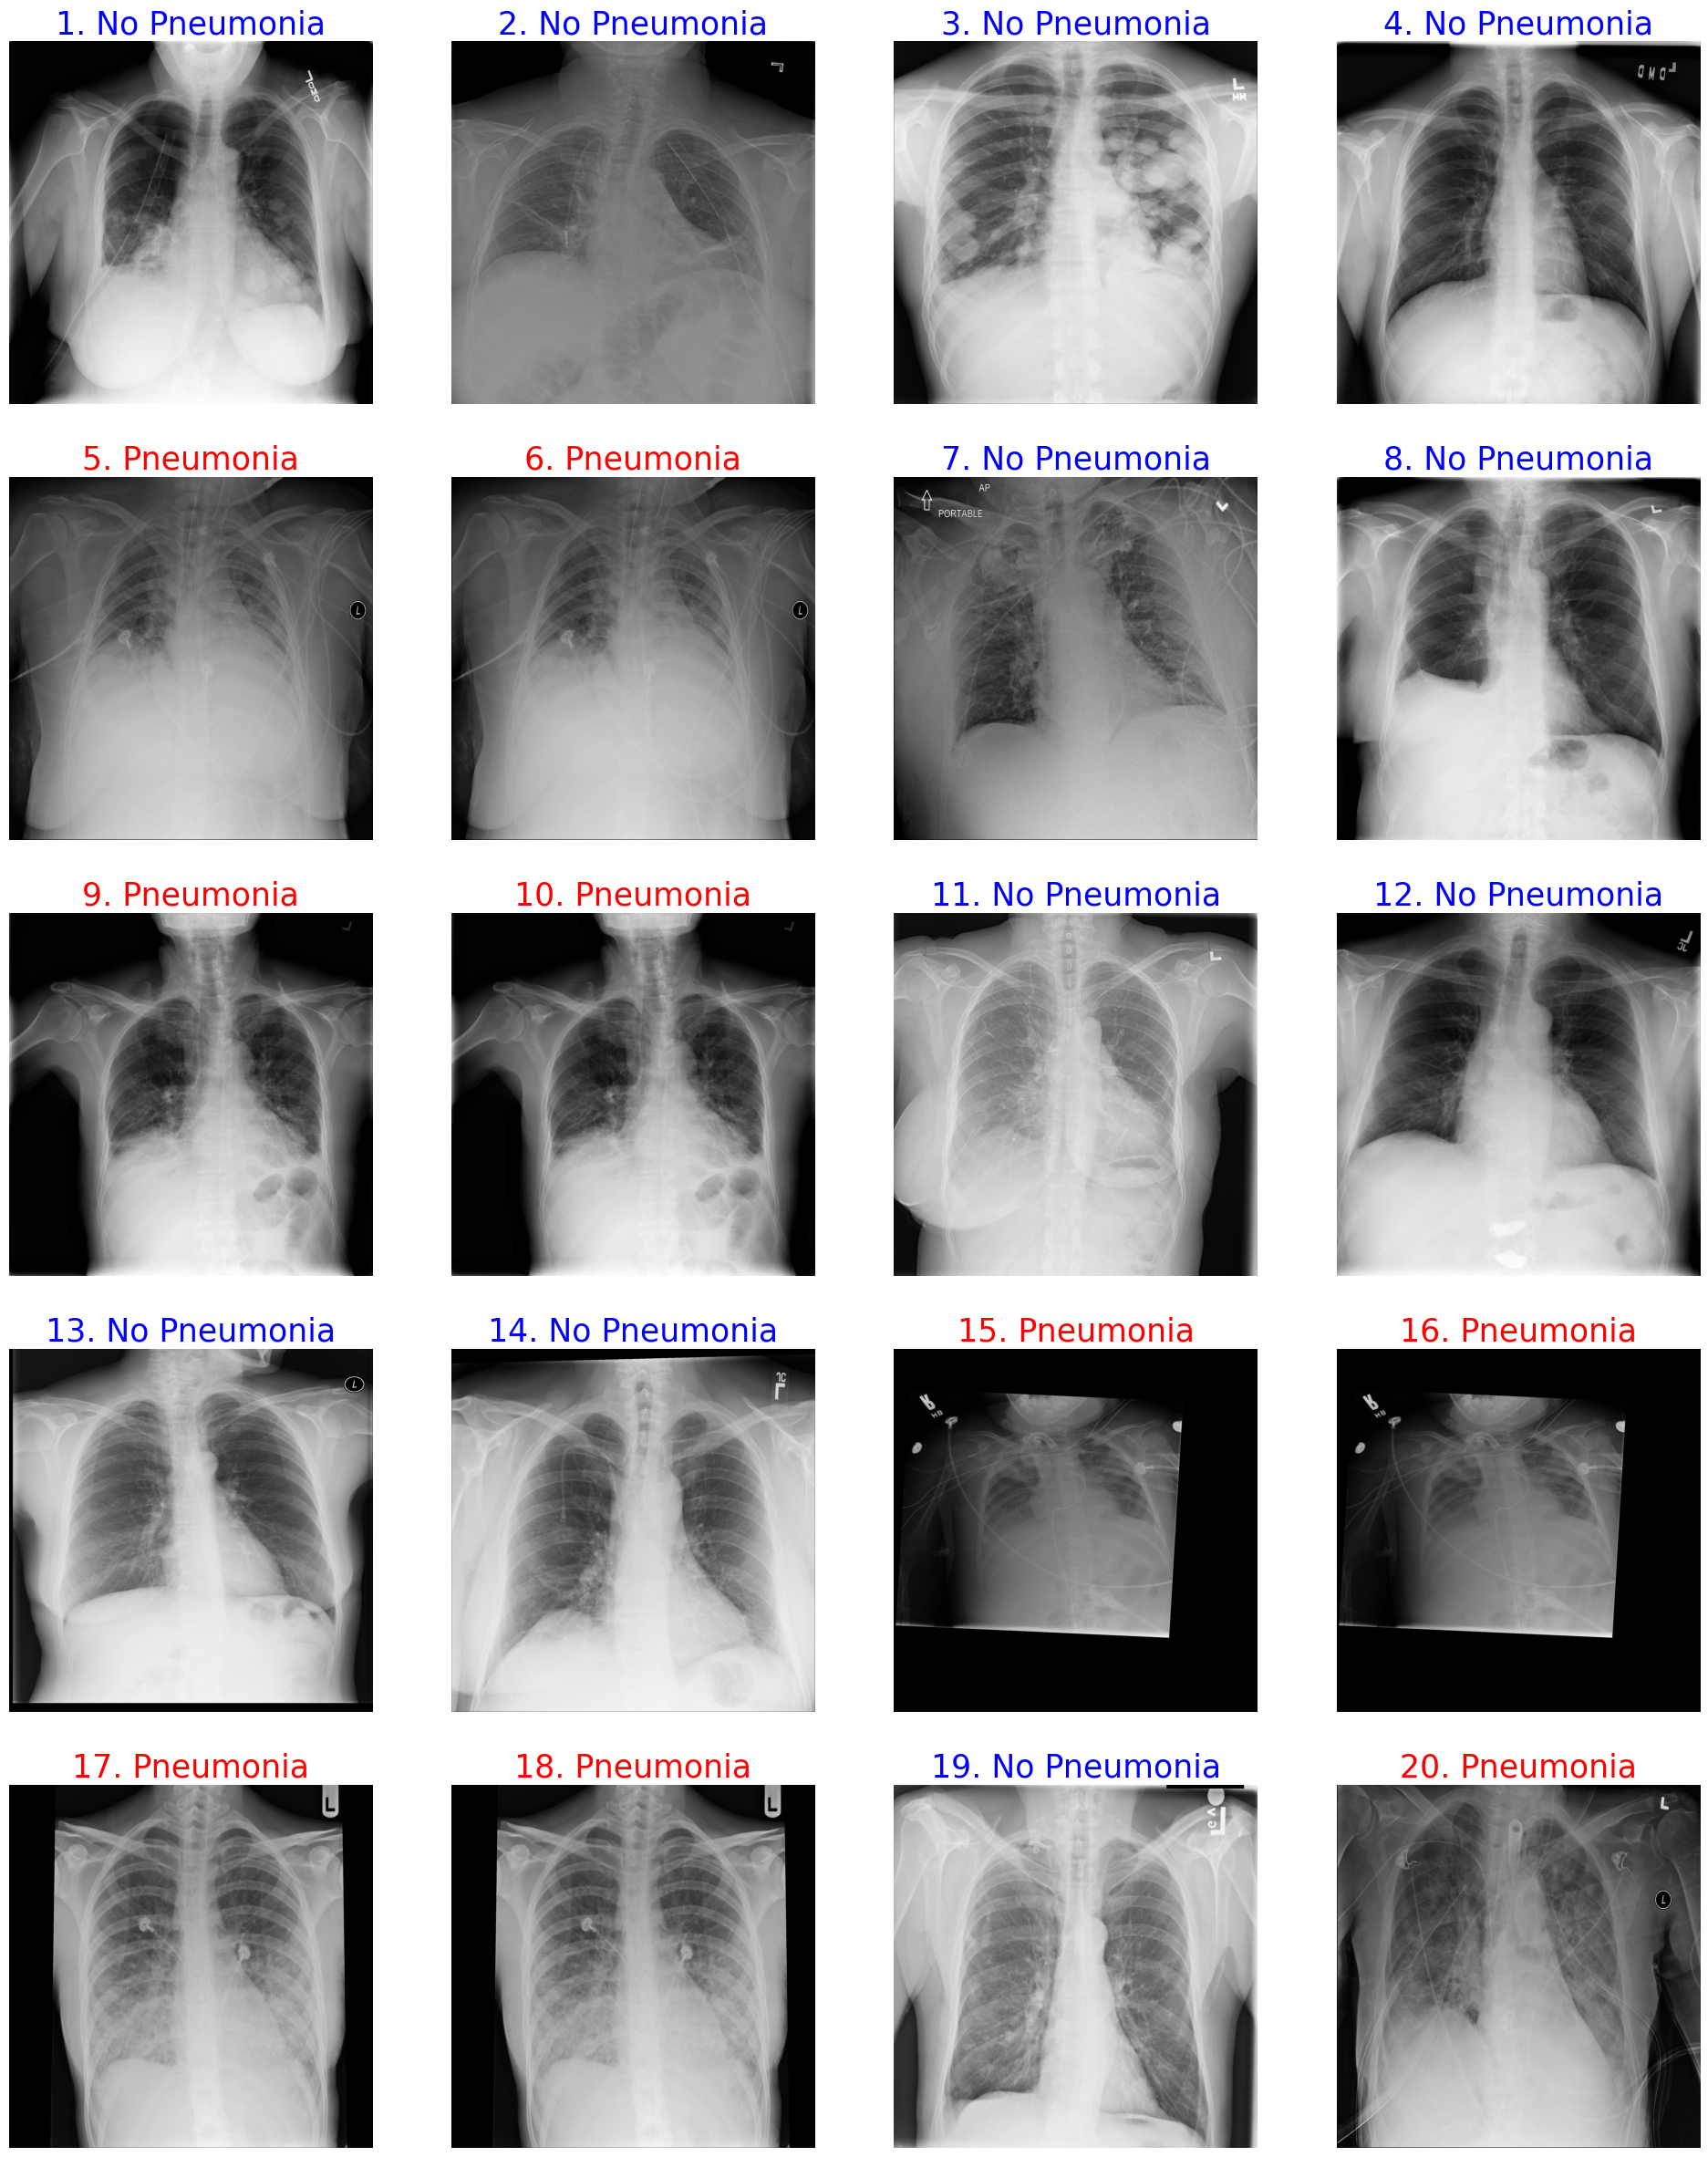

In [25]:
plt.figure(figsize=(24,30)) #
i = 0
for i, image in enumerate(image_arrays[:20]):
    plt.subplot(5,4,i+1)
    plt.imshow(image, cmap='gray')
    if df4.loc[i]["Target"]:
        plt.title(str(i+1)+". Pneumonia", color="red", fontsize=25)
    else:
        plt.title(str(i+1)+". No Pneumonia", color="blue", fontsize=25)
    plt.axis('off')
plt.show()

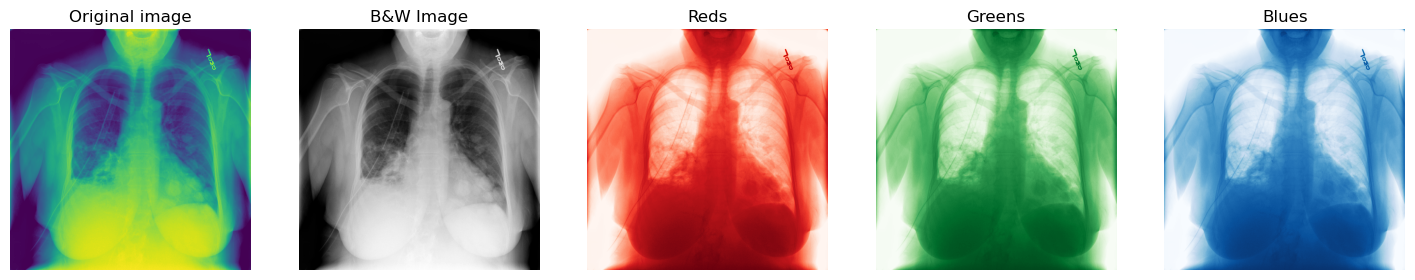

In [26]:
#Image Testing with different color codes

dicom_data = dicom_images[0]

fig, axes = plt.subplots(1, 5, figsize=(18, 8))
axes[0].imshow(dicom_data.pixel_array)
axes[0].set_title('Original image')

axes[1].imshow(dicom_data.pixel_array, cmap=plt.cm.gray)
axes[1].set_title('B&W Image')

axes[2].imshow(dicom_data.pixel_array, cmap=plt.get_cmap('Reds'))
axes[2].set_title('Reds')

axes[3].imshow(dicom_data.pixel_array, cmap=plt.get_cmap('Greens'))
axes[3].set_title('Greens')

axes[4].imshow(dicom_data.pixel_array, cmap=plt.get_cmap('Blues'))
axes[4].set_title('Blues')

for ax in axes:
  ax.axis('off')

plt.show()

## Step 3: Map training and testing images to its annotations.

In [27]:
# Function to get annotations for a given image filename
i = 0
def get_annotations_for_image(filename, annotations_df):
    annotations = []
    rows = annotations_df[annotations_df["patientId"] == filename[:-4]]
    for i, row in rows.iterrows():
        annotation = {
            "x": row["x"],
            "y": row["y"],
            "width": row["width"],
            "height": row["height"],
            "class": "Pneumonia" if row["Target"] == 1 else "Normal"
        }
        i = 1
        annotations.append(annotation)
    return annotations

# Create a dictionary to store annotations for each image filename
image_annotations = {
    os.path.basename(dcm_file.filename): get_annotations_for_image(os.path.basename(dcm_file.filename), df4)
    for dcm_file in dicom_images
}

In [28]:
print(len(image_arrays),' = ',len(df4['class']),' = ',len(image_annotations))
print('Print sample annotation => ',image_annotations['00313ee0-9eaa-42f4-b0ab-c148ed3241cd.dcm'])

800  =  800  =  661
Print sample annotation =>  [{'x': nan, 'y': nan, 'width': nan, 'height': nan, 'class': 'Normal'}]


In [29]:
# Convert the dictionary into lists of filenames and annotations
filenames = list(image_annotations.keys())
annotations = list(image_annotations.values())

# Split the data into training and test sets into 80:20 respectively
train_filenames, test_filenames, train_annotations, test_annotations = train_test_split(
    filenames, annotations, test_size=0.2, random_state=42
)

# Convert the split lists back to dictionaries
train_image_annotations = {filename: annotation for filename, annotation in zip(train_filenames, train_annotations)}
test_image_annotations = {filename: annotation for filename, annotation in zip(test_filenames, test_annotations)}

In [30]:
print('train_image_annotations shape =>', len(train_image_annotations))
print('test_image_annotations shape =>',len( test_image_annotations))

train_image_annotations shape => 528
test_image_annotations shape => 133


In [31]:
sample_trainigdata = df4.groupby('class', group_keys=False).apply(lambda x: x.sample(200))

In [32]:
sample_trainigdata["class"].value_counts()

Lung Opacity                    200
No Lung Opacity / Not Normal    200
Normal                          200
Name: class, dtype: int64

In [33]:
sample_trainigdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 182 to 205
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  600 non-null    object 
 1   class      600 non-null    object 
 2   x          200 non-null    float64
 3   y          200 non-null    float64
 4   width      200 non-null    float64
 5   height     200 non-null    float64
 6   Target     600 non-null    int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 37.5+ KB


In [34]:
from tensorflow.keras.applications.mobilenet import preprocess_input

images = []
ADJUSTED_IMAGE_SIZE = 128
imageList = []
classLabels = []
labels = []
originalImage = []
# Function to read the image from the path and reshape the image to size
def readAndReshapeImage(image):
    img = np.array(image).astype(np.uint8)
    ## Resize the image
    res = cv2.resize(img,(ADJUSTED_IMAGE_SIZE,ADJUSTED_IMAGE_SIZE), interpolation = cv2.INTER_LINEAR)
    return res

## Read the imahge and resize the image
def populateImage(rowData):
    for index, row in rowData.iterrows():
        patientId = row.patientId
        classlabel = row["class"]
        dcm_file = _path+'{}.dcm'.format(patientId)
        dcm_data = dcm.read_file(dcm_file)
        img = dcm_data.pixel_array
        ## Converting the image to 3 channels as the dicom
        if len(img.shape) != 3 or img.shape[2] != 3:
            img = np.stack((img,) * 3, -1)
        imageList.append(readAndReshapeImage(img))
        classLabels.append(classlabel)
    tmpImages = np.array(imageList)
    tmpLabels = np.array(classLabels)
    return tmpImages,tmpLabels

In [35]:
images,labels = populateImage(sample_trainigdata)

In [36]:
images.shape , labels.shape

((600, 128, 128, 3), (600,))

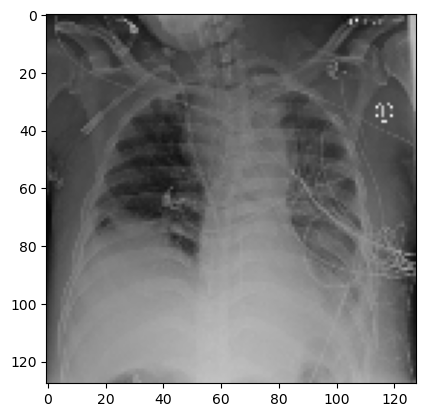

In [37]:
plt.imshow(images[100])

In [38]:
np.unique(labels),len(np.unique(labels))

(array(['Lung Opacity', 'No Lung Opacity / Not Normal', 'Normal'],
       dtype='<U28'),
 3)

In [39]:
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y2 = enc.fit_transform(labels)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(images, y2, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state=50)

## Step 4: Preprocessing and Visualisation of different classes

In [41]:
# Convert the lists to NumPy arrays for easier manipulation
train_images = np.array(train_image_annotations)
val_images = np.array(test_image_annotations)

In [42]:
# Create a dictionary to store samples for each class
class_samples = defaultdict(list)
#pneumonia_samples = defaultdict(list)

# Iterate through the annotations
for image_filename, bbox_list in image_annotations.items():
    for bbox in bbox_list:
        class_name = bbox['class']
        
        if class_name != 'Pneumonia' and len(class_samples[class_name]) < 5:
            image_filename = image_filename.replace(".dcm", "")
            class_samples[class_name].append(image_filename)
            
        if class_name != 'Normal' and len(class_samples[class_name]) < 5:
            image_filename = image_filename.replace(".dcm", "")
            class_samples[class_name].append(image_filename)

# Print the collected samples
for class_name, samples in class_samples.items():
    print("Class name:", class_name)
    print("Images:", samples)
    print("\n")


Class name: Normal
Images: ['0004cfab-14fd-4e49-80ba-63a80b6bddd6', '00313ee0-9eaa-42f4-b0ab-c148ed3241cd', '00322d4d-1c29-4943-afc9-b6754be640eb', '003d8fa0-6bf1-40ed-b54c-ac657f8495c5', '00569f44-917d-4c86-a842-81832af98c30']


Class name: Pneumonia
Images: ['00436515-870c-4b36-a041-de91049b9ab4', '00436515-870c-4b36-a041-de91049b9ab4', '00704310-78a8-4b38-8475-49f4573b2dbb', '00704310-78a8-4b38-8475-49f4573b2dbb', '00aecb01-a116-45a2-956c-08d2fa55433f']




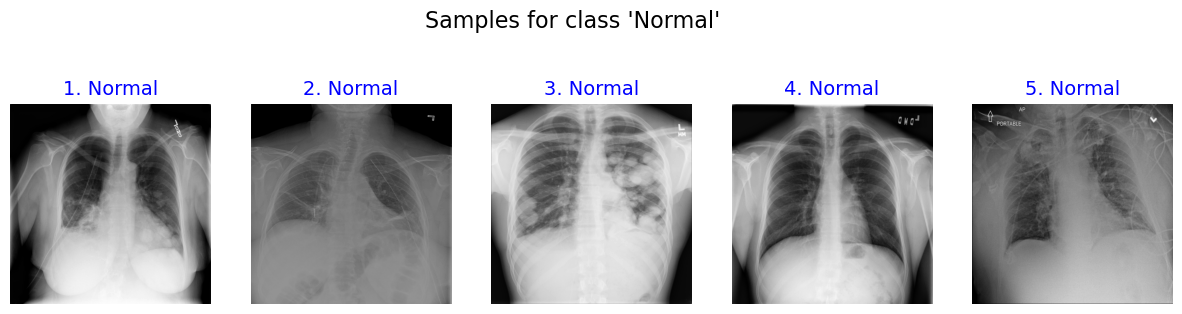

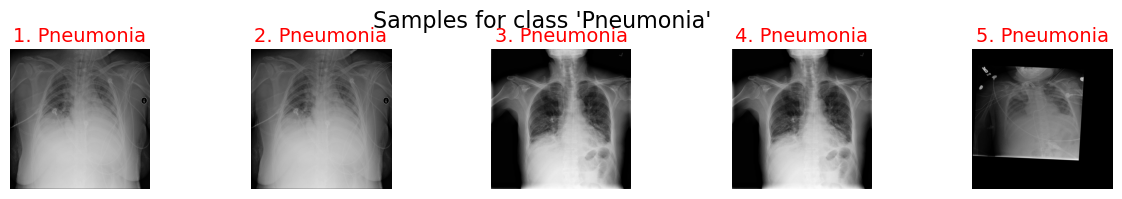

In [43]:
# Directory to save converted images
output_dir = "stage_2_train_images"
os.makedirs(output_dir, exist_ok=True)
# Display images with their corresponding class names
kk = 0
color = ['blue','red']
for class_name, samples in class_samples.items():
    plt.figure(figsize=(15, 4))
    plt.suptitle(f"Samples for class '{class_name}'", fontsize=16)
    print("\n")
    kk += 1
    for i, image_filename in enumerate(samples):
        dcm_path = os.path.join(output_dir, image_filename + ".dcm")
        png_path = os.path.join(output_dir, image_filename + ".png")
        
        dcm_image = dcm.dcmread(dcm_path)
        image_data = dcm_image.pixel_array
        
        plt.subplot(kk, 5, i + 1)
        plt.imshow(image_data, cmap='gray')
        plt.title(str(i+1)+". "+class_name, color=color[kk-1], fontsize=14)
        plt.axis('off')
    
    plt.show()
    

## Step 5: Display images with bounding box.

<Figure size 2000x400 with 0 Axes>

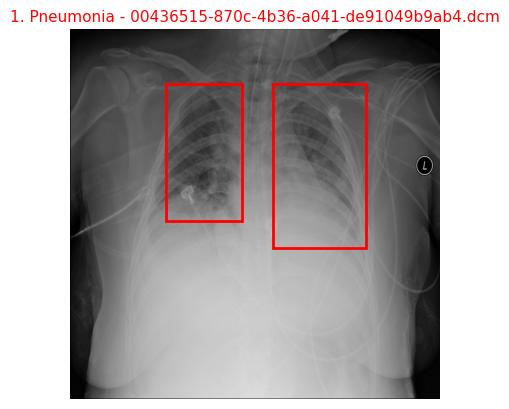

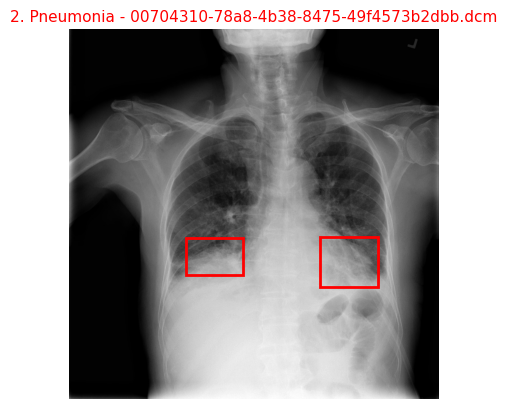

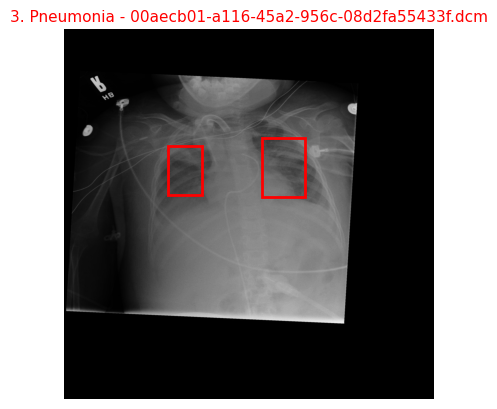

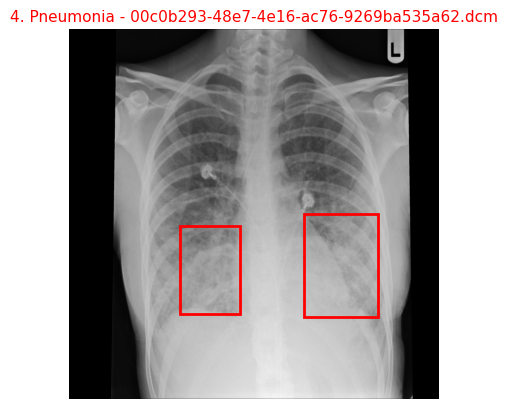

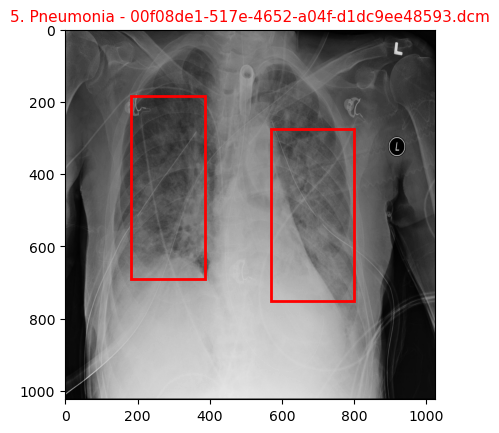

In [44]:
# Function to draw bounding boxes on images
def draw_bounding_boxes(images_dict):
    plt.figure(figsize=(20,4)) #
    i = 0
    ik = 0
    for image_filename, annotations in images_dict.items():
        ik += 1
        class_name = annotations[0]['class']
        #print(class_name)
        if class_name != 'Normal':
            image_path = _path+image_filename
            image = cv2.imread(image_path)
            
            i += 1
            # Create a figure and axes
            fig, ax = plt.subplots(1)
            ax.imshow(dcm.dcmread(image_path).pixel_array, cmap='gray')

            # Loop through the bounding box annotations and draw each bounding box on the image
            for annotation in annotations:
                x = annotation['x']
                y = annotation['y']
                width = annotation['width']
                height = annotation['height']
                _class = annotation['class']
                if _class == 'Pneumonia':
                    color="red"
                else:
                    color="blue"
                    
                ax.set_title(str(i)+'. '+annotation['class']+' - '+image_filename, color=color, fontsize=11)
                # Create a Rectangle patch
                rect = Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')

                # Add the Rectangle patch to the axes
                ax.add_patch(rect)
                
            if i == 5:
                break # This will exit the loop when i becomes 5

        # Set axis properties
            ax.axis('off')
        # Show the image with the bounding boxes
        plt.show()

draw_bounding_boxes(image_annotations)


## Step 6: Design, train and test basic CNN models for classification.

In [45]:
def createResultDf(name,accuracy,testscore):
    result = pd.DataFrame({'Method':[name], 'accuracy': [accuracy] ,'Test Score':[testscore]})
    return result

In [46]:
def cnn_model(height, width, num_channels, num_classes, loss='categorical_crossentropy', metrics=['accuracy']):
  batch_size = None

  model = Sequential()

  model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', batch_input_shape = (batch_size,height, width, num_channels)))


  model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.2))


  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.3))

  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.4))

  model.add(GlobalMaxPooling2D())
  model.add(Dense(256, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation = "softmax"))

  optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  model.summary()
  return model

In [47]:
# Model Summary
from tensorflow.keras.optimizers.legacy import RMSprop
ADJUSTED_IMAGE_SIZE = 128
cnn = cnn_model(ADJUSTED_IMAGE_SIZE,ADJUSTED_IMAGE_SIZE,3,3)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                   

In [48]:
#history = cnn.fit(X_train, y_train, epochs = 10, validation_data = (X_val,y_val), batch_size = 32)

In [49]:
#fcl_loss, fcl_accuracy = cnn.evaluate(X_test, y_test, verbose=1)
#print('Test loss:', fcl_loss)
#print('Test accuracy:', fcl_accuracy)

In [50]:
history = cnn.fit(X_train,
                  y_train,
                  epochs = 10,
                  validation_data = (X_val,y_val),
                  batch_size = 32)

Epoch 1/10
14/14 [==============================] - 27s 2s/step - loss: 26.5149 - accuracy: 0.3214 - val_loss: 1.1648 - val_accuracy: 0.3778
Epoch 2/10
14/14 [==============================] - 26s 2s/step - loss: 1.8053 - accuracy: 0.2905 - val_loss: 1.1110 - val_accuracy: 0.4000
Epoch 3/10
14/14 [==============================] - 24s 2s/step - loss: 1.2843 - accuracy: 0.3000 - val_loss: 1.1043 - val_accuracy: 0.3000
Epoch 4/10
14/14 [==============================] - 23s 2s/step - loss: 1.1960 - accuracy: 0.3714 - val_loss: 1.1219 - val_accuracy: 0.3889
Epoch 5/10
14/14 [==============================] - 24s 2s/step - loss: 1.1669 - accuracy: 0.3738 - val_loss: 1.1177 - val_accuracy: 0.2667
Epoch 6/10
14/14 [==============================] - 25s 2s/step - loss: 1.1379 - accuracy: 0.3333 - val_loss: 1.0880 - val_accuracy: 0.3222
Epoch 7/10
14/14 [==============================] - 22s 2s/step - loss: 1.1253 - accuracy: 0.3690 - val_loss: 1.1207 - val_accuracy: 0.2889
Epoch 8/10
14/14 [=

In [51]:
fcl_loss, fcl_accuracy = cnn.evaluate(X_test, y_test, verbose=1)
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)

3/3 [==============================] - 1s 234ms/step - loss: 1.1038 - accuracy: 0.3000
Test loss: 1.1038349866867065
Test accuracy: 0.30000001192092896


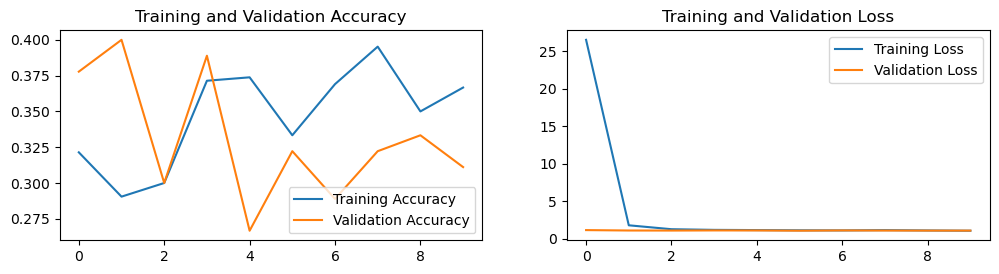

In [52]:
## PLottting the accuracy vs loss graph
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(10)

plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [53]:
resultDF = createResultDf("CNN",acc[-1],fcl_accuracy)

3/3 [==============================] - 1s 202ms/step


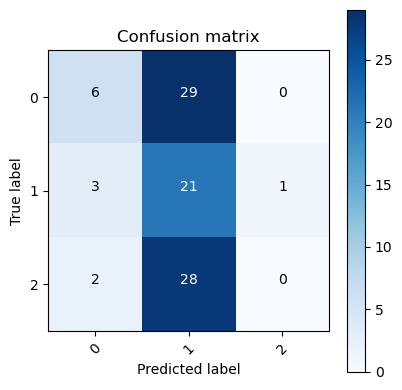

In [54]:
from sklearn.metrics import confusion_matrix
import itertools
plt.subplots(figsize=(4,4)) #set the size of the plot

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = cnn.predict(X_test)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3))

In [55]:
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, roc_auc_score,classification_report
from sklearn.metrics import classification_report

Y_truepred = np.argmax(y_test,axis = 1)

Y_testPred = cnn.predict(X_test)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)

reportData = classification_report(Y_truepred, Y_pred_classes,output_dict=True)

for data in reportData:
    if(data == '-1' or data == '1'):
        if(type(reportData[data]) is dict):
            for subData in reportData[data]:
                resultDF[data+"_"+subData] = reportData[data][subData]

resultDF

3/3 [==============================] - 1s 208ms/step


Method  accuracy  Test Score  1_precision  1_recall  1_f1-score  1_support
0    CNN  0.366667         0.3     0.269231      0.84    0.407767         25

# Milestone 2

In [56]:
## Creating a Copy for milestone 2 from 1
X_train1 = X_train.copy()
y_train1 = y_train.copy()
X_val1 = X_val.copy()
y_val1 = y_val.copy()
X_test1 = X_test.copy()
y_test1 = y_test.copy()

## Step 1: Fine tune the trained basic CNN models for classification.

In [57]:
ADJUSTED_IMAGE_SIZE = 128
input_shape = (ADJUSTED_IMAGE_SIZE, ADJUSTED_IMAGE_SIZE, 3)
num_classes = y_train1.shape[1]

# model.summary()

model = Sequential()
model.add(RandomRotation(factor=0.15))
model.add(Rescaling(1./255))
model.add(Conv2D(32, (3, 3), input_shape=input_shape))

model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3)))

model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3)))

model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=AdamW(learning_rate=0.0005),
              metrics=['accuracy'] # ,f1_m
             )

In [58]:
history = model.fit(X_train1,
                  y_train1,
                  epochs = 10,
                  validation_data = (X_val1,y_val1),
                  batch_size = 40)

Epoch 1/10
11/11 [==============================] - 5s 349ms/step - loss: 1.1579 - accuracy: 0.3190 - val_loss: 1.0985 - val_accuracy: 0.3556
Epoch 2/10
11/11 [==============================] - 4s 334ms/step - loss: 1.1043 - accuracy: 0.3452 - val_loss: 1.0994 - val_accuracy: 0.3333
Epoch 3/10
11/11 [==============================] - 4s 343ms/step - loss: 1.0860 - accuracy: 0.3905 - val_loss: 1.0993 - val_accuracy: 0.3111
Epoch 4/10
11/11 [==============================] - 4s 356ms/step - loss: 1.0900 - accuracy: 0.3548 - val_loss: 1.0980 - val_accuracy: 0.3111
Epoch 5/10
11/11 [==============================] - 4s 347ms/step - loss: 1.0820 - accuracy: 0.3595 - val_loss: 1.0928 - val_accuracy: 0.3556
Epoch 6/10
11/11 [==============================] - 4s 371ms/step - loss: 1.0697 - accuracy: 0.4333 - val_loss: 1.0803 - val_accuracy: 0.3667
Epoch 7/10
11/11 [==============================] - 4s 355ms/step - loss: 1.0683 - accuracy: 0.3762 - val_loss: 1.0729 - val_accuracy: 0.4222
Epoch 

In [59]:
fcl_loss, fcl_accuracy = model.evaluate(X_test1, y_test1, verbose=1)
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)

3/3 [==============================] - 0s 66ms/step - loss: 1.0140 - accuracy: 0.5667
Test loss: 1.0139909982681274
Test accuracy: 0.5666666626930237


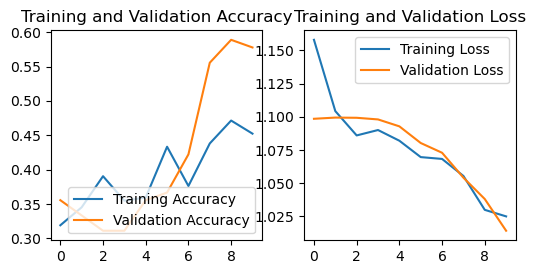

In [60]:
## PLottting the accuracy vs loss graph after tuning the model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(10)

plt.figure(figsize=(6, 6))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [61]:
resultTunedDF = createResultDf("CNN",acc[-1],fcl_accuracy)

3/3 [==============================] - 0s 51ms/step


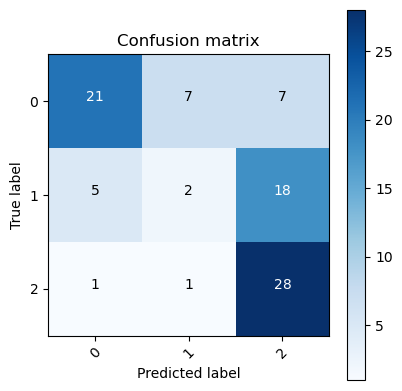

In [62]:
from sklearn.metrics import confusion_matrix
import itertools
plt.subplots(figsize=(4,4)) #set the size of the plot

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_test1)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test1,axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3))

In [63]:
Y_truepred = np.argmax(y_test1,axis = 1)

Y_testPred = model.predict(X_test1)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)

reportData = classification_report(Y_truepred, Y_pred_classes,output_dict=True)

for data in reportData:
    if(data == '-1' or data == '1'):
        if(type(reportData[data]) is dict):
            for subData in reportData[data]:
                resultTunedDF[data+"_"+subData] = reportData[data][subData]

resultTunedDF

3/3 [==============================] - 0s 47ms/step


Method  accuracy  Test Score  1_precision  1_recall  1_f1-score  1_support
0    CNN  0.452381    0.566667          0.2      0.08    0.114286         25

## Step 2: Apply Transfer Learning model for classification

##### *CNN with Tranfer learning using VGG16*

In [64]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

base_model = VGG16(weights="imagenet", include_top=False)
for layer in base_model.layers:
      layer.trainable = False

In [65]:
# Data Augmentation Step
augment = Sequential([RandomRotation(0.15)], name='AugmentationLayer')
inputs=Input(shape=input_shape,name='inputLayer')

x = augment(inputs)
pretrain_out = base_model(x, training = False)
x = Flatten()(pretrain_out)
x = Dense(64, activation='relu')(x)
x = Dense(y_train1.shape[1], name='outputLayer')(x)
outputs = Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x)
model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=AdamW(learning_rate=0.0005), #
                   loss=losses.categorical_crossentropy,
                   metrics=['accuracy']) # ,f1_m

In [66]:
history = model.fit(X_train1,
                    y_train1,
                    batch_size=60,
                    epochs=10,
                    validation_data=(X_test1, y_test1),
                    callbacks=[EarlyStopping(monitor = "val_loss", patience = 15, restore_best_weights = True, mode='min'),
                    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')])

Epoch 1/10
7/7 [==============================] - 29s 4s/step - loss: 10.2991 - accuracy: 0.3762 - val_loss: 4.5337 - val_accuracy: 0.3667 - lr: 5.0000e-04
Epoch 2/10
7/7 [==============================] - 25s 4s/step - loss: 2.4838 - accuracy: 0.5143 - val_loss: 1.0677 - val_accuracy: 0.6333 - lr: 5.0000e-04
Epoch 3/10
7/7 [==============================] - 29s 4s/step - loss: 1.2037 - accuracy: 0.5643 - val_loss: 0.9242 - val_accuracy: 0.5778 - lr: 5.0000e-04
Epoch 4/10
7/7 [==============================] - 25s 4s/step - loss: 0.9144 - accuracy: 0.5595 - val_loss: 0.8866 - val_accuracy: 0.6111 - lr: 5.0000e-04
Epoch 5/10
7/7 [==============================] - 29s 4s/step - loss: 0.8572 - accuracy: 0.6000 - val_loss: 0.8482 - val_accuracy: 0.6111 - lr: 5.0000e-04
Epoch 6/10
7/7 [==============================] - 31s 5s/step - loss: 0.7951 - accuracy: 0.6167 - val_loss: 0.8354 - val_accuracy: 0.6000 - lr: 5.0000e-04
Epoch 7/10
7/7 [==============================] - 29s 4s/step - loss:

In [67]:
test_ds = preprocess_input(X_test1)
fcl_loss, fcl_accuracy = model.evaluate(test_ds, y_test1, verbose=1)
#fcl_loss, fcl_accuracy = cnn_VGG16_model.evaluate(test_ds, y_test1, verbose=1)
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)

3/3 [==============================] - 5s 2s/step - loss: 0.8598 - accuracy: 0.6556
Test loss: 0.8598067164421082
Test accuracy: 0.6555555462837219


In [68]:
resultsDf1 = pd.concat([resultDF, createResultDf("CNN With VGG16",0.9571,fcl_accuracy)])

In [69]:
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, roc_auc_score,classification_report
from sklearn.metrics import classification_report

Y_truepred = np.argmax(y_test1,axis = 1)

Y_testPred = cnn.predict(test_ds)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)

reportData = classification_report(Y_truepred, Y_pred_classes,output_dict=True)

for data in reportData:
    if(data == '-1' or data == '1'):
        if(type(reportData[data]) is dict):
            for subData in reportData[data]:
                resultsDf1[data+"_"+subData] = reportData[data][subData]

resultsDf1

3/3 [==============================] - 1s 211ms/step


Method  accuracy  Test Score  1_precision  1_recall  1_f1-score  \
0             CNN  0.366667    0.300000          0.2      0.08    0.114286   
0  CNN With VGG16  0.957100    0.655556          0.2      0.08    0.114286   

   1_support  
0         25  
0         25

## 3: Design, train and test RCNN & its hybrids based object detection models to impose the bounding box or mask over the area of interest.

In [70]:
# reference drawn from https://www.kaggle.com/code/numbrami/classification-task-on-rsna-pneumonia

In [159]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import regularizers

#Using ResNet50 as a base model

base_model_resnet = ResNet50(weights = 'imagenet', input_shape = input_shape, include_top=False, pooling='avg' )

for l in base_model_resnet.layers[:-4]:
    l.trainable=False

In [160]:
#Building ResNet50 model
model_resnet = Sequential()
model_resnet.add(base_model_resnet)
model_resnet.add(BatchNormalization())


model_resnet.add(Dense(256, kernel_regularizer=regularizers.l2(0.01)))
model_resnet.add(BatchNormalization())
model_resnet.add(Activation(activation='relu'))
model_resnet.add(Dropout(0.3))


model_resnet.add(Dense(128, kernel_regularizer=regularizers.l2(0.01)))
model_resnet.add(BatchNormalization())
model_resnet.add(Activation(activation='relu'))
model_resnet.add(Dropout(0.3))


model_resnet.add(Dense(64, kernel_regularizer=regularizers.l2(0.01)))
model_resnet.add(BatchNormalization())
model_resnet.add(Activation(activation='relu'))
model_resnet.add(Dropout(0.3))


model_resnet.add(Dense(32, kernel_regularizer=regularizers.l2(0.01)))
model_resnet.add(BatchNormalization())
model_resnet.add(Activation(activation='relu'))
model_resnet.add(Dropout(0.3))


model_resnet.add(Dense(16, kernel_regularizer=regularizers.l2(0.01)))
model_resnet.add(BatchNormalization())
model_resnet.add(Activation(activation='relu'))
model_resnet.add(Dropout(0.3))

model_resnet.add(Dense(3, activation = 'softmax'))

In [161]:
model_resnet.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 batch_normalization_12 (Ba  (None, 2048)              8192      
 tchNormalization)                                               
                                                                 
 dense_17 (Dense)            (None, 256)               524544    
                                                                 
 batch_normalization_13 (Ba  (None, 256)               1024      
 tchNormalization)                                               
                                                                 
 activation_15 (Activation)  (None, 256)               0         
                                                                 
 dropout_18 (Dropout)        (None, 256)              

In [162]:
#Compiling Model
model_resnet.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#history_resnet = model_resnet.fit(X_train, y_train, epochs = 10, batch_size=32, validation_split=0.7)
history_resnet = model_resnet.fit(X_train1, y_train1,  epochs = 10, validation_data = (X_val1,y_val1), batch_size = 32)


Epoch 1/10
14/14 [==============================] - 15s 780ms/step - loss: 8.2855 - accuracy: 0.3357 - val_loss: 7.7323 - val_accuracy: 0.3889
Epoch 2/10
14/14 [==============================] - 13s 934ms/step - loss: 7.5828 - accuracy: 0.4095 - val_loss: 7.1414 - val_accuracy: 0.3667
Epoch 3/10
14/14 [==============================] - 12s 873ms/step - loss: 6.9791 - accuracy: 0.4071 - val_loss: 6.5782 - val_accuracy: 0.4333
Epoch 4/10
14/14 [==============================] - 12s 874ms/step - loss: 6.4230 - accuracy: 0.3929 - val_loss: 6.0762 - val_accuracy: 0.5889
Epoch 5/10
14/14 [==============================] - 12s 842ms/step - loss: 5.9110 - accuracy: 0.4810 - val_loss: 5.5923 - val_accuracy: 0.6222
Epoch 6/10
14/14 [==============================] - 12s 836ms/step - loss: 5.4633 - accuracy: 0.4976 - val_loss: 5.2213 - val_accuracy: 0.6333
Epoch 7/10
14/14 [==============================] - 12s 833ms/step - loss: 5.0764 - accuracy: 0.5333 - val_loss: 4.8409 - val_accuracy: 0.6222

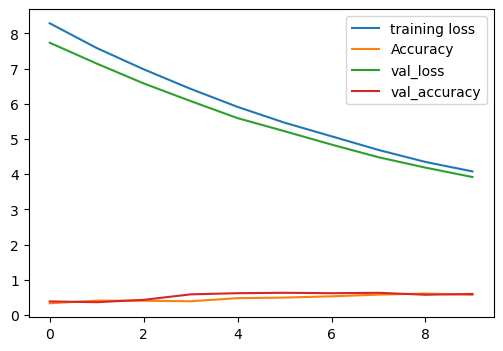

In [163]:
plt.figure(figsize=(6,4))

plt.plot(history_resnet.history['loss'], label='training loss');
plt.plot(history_resnet.history['accuracy'], label='Accuracy');
plt.plot(history_resnet.history['val_loss'], label='val_loss');
plt.plot(history_resnet.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [164]:
model_resnet.evaluate(x = X_train, y = y_train, batch_size = 32)

14/14 [==============================] - 9s 663ms/step - loss: 3.9075 - accuracy: 0.6143


[3.907456398010254, 0.6142857074737549]

In [165]:
#Building Model: EfficientNet B3
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB3, EfficientNetB7

base_model_eff_b3 = EfficientNetB3(weights= 'imagenet',input_shape = input_shape , include_top=False, pooling='avg')
for l in base_model_eff_b3.layers[:-6]:
    l.trainable=False

In [78]:
#Building a model
model_efficient = Sequential()
model_efficient.add(base_model_eff_b3)
model_efficient.add(BatchNormalization())


model_efficient.add(Dense(256, kernel_regularizer=regularizers.l2(0.01)))
model_efficient.add(BatchNormalization())
model_efficient.add(Activation(activation='relu'))

model_efficient.add(Dropout(0.3))



model_efficient.add(Dense(128, kernel_regularizer=regularizers.l2(0.01)))
model_efficient.add(BatchNormalization())
model_efficient.add(Activation(activation='relu'))

model_efficient.add(Dropout(0.3))



model_efficient.add(Dense(64, kernel_regularizer=regularizers.l2(0.01)))
model_efficient.add(BatchNormalization())
model_efficient.add(Activation(activation='relu'))

model_efficient.add(Dropout(0.3))


model_efficient.add(Dense(32, kernel_regularizer=regularizers.l2(0.01)))
model_efficient.add(BatchNormalization())
model_efficient.add(Activation(activation='relu'))

model_efficient.add(Dropout(0.3))


model_efficient.add(Dense(16, kernel_regularizer=regularizers.l2(0.01)))
model_efficient.add(BatchNormalization())
model_efficient.add(Activation(activation='relu'))

model_efficient.add(Dropout(0.3))

model_efficient.add(Dense(3, activation = 'sigmoid'))

In [79]:
model_efficient.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization_6 (Bat  (None, 1536)              6144      
 chNormalization)                                                
                                                                 
 dense_11 (Dense)            (None, 256)               393472    
                                                                 
 batch_normalization_7 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 activation_10 (Activation)  (None, 256)               0         
                                                      

In [80]:
model_efficient.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history_efficient = model_efficient.fit(X_train, y_train, epochs = 15, validation_split=0.7)

Epoch 1/15
4/4 [==============================] - 22s 4s/step - loss: 8.3241 - accuracy: 0.3810 - val_loss: 8.0919 - val_accuracy: 0.3707
Epoch 2/15
4/4 [==============================] - 10s 3s/step - loss: 8.1393 - accuracy: 0.3730 - val_loss: 7.8780 - val_accuracy: 0.4014
Epoch 3/15
4/4 [==============================] - 10s 3s/step - loss: 7.8957 - accuracy: 0.3651 - val_loss: 7.6578 - val_accuracy: 0.4184
Epoch 4/15
4/4 [==============================] - 9s 3s/step - loss: 7.6399 - accuracy: 0.3889 - val_loss: 7.4346 - val_accuracy: 0.4422
Epoch 5/15
4/4 [==============================] - 10s 3s/step - loss: 7.3575 - accuracy: 0.4841 - val_loss: 7.2070 - val_accuracy: 0.4728
Epoch 6/15
4/4 [==============================] - 10s 3s/step - loss: 7.1277 - accuracy: 0.4762 - val_loss: 6.9769 - val_accuracy: 0.4830
Epoch 7/15
4/4 [==============================] - 9s 3s/step - loss: 6.9177 - accuracy: 0.4524 - val_loss: 6.7460 - val_accuracy: 0.4966
Epoch 8/15
4/4 [====================

In [81]:
model_efficient.evaluate(x = X_train, y = y_train, batch_size = 32)

14/14 [==============================] - 9s 671ms/step - loss: 5.0262 - accuracy: 0.5214


[5.026247978210449, 0.5214285850524902]

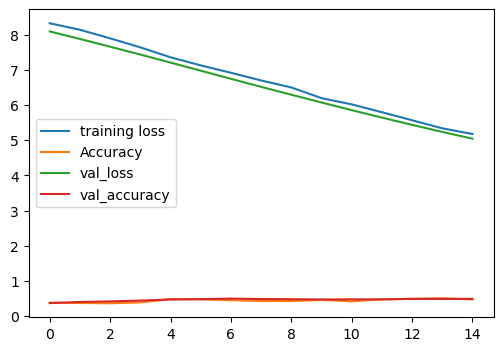

In [82]:
plt.figure(figsize=(6,4))

plt.plot(history_efficient.history['loss'], label='training loss');
plt.plot(history_efficient.history['accuracy'], label='Accuracy');
plt.plot(history_efficient.history['val_loss'], label='val_loss');
plt.plot(history_efficient.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

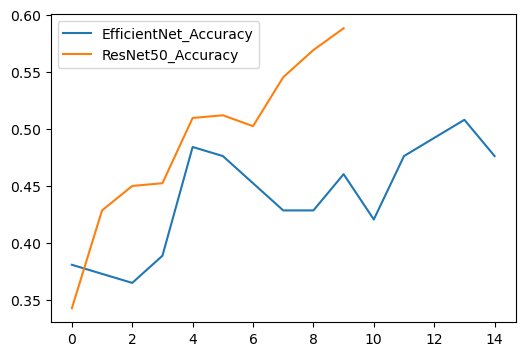

In [83]:
#Compare the result of ResNet50 and EfficientNet B3
plt.figure(figsize=(6,4))

plt.plot(history_efficient.history['accuracy'], label='EfficientNet_Accuracy');
plt.plot(history_resnet.history['accuracy'], label='ResNet50_Accuracy');

plt.legend()

In [84]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

#Now we will use Keras ImageDataGenerator to pass the dataset to the model. We will do some augmentation on the 
#dataset like horizontal flip, vertical flip and rotation to increase the dataset.

trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
train_data = trdata.flow(x=X_train1, y=y_train1)
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
test_data = tsdata.flow(x=X_test1, y=y_test1)

In [85]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoints = ModelCheckpoint("ieeercnn_vgg16_1.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq="epoch")
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=100, verbose=1, mode='auto')

In [86]:
#Now we start the training of the model using fit() method.

history = model.fit(train_data, steps_per_epoch= 10, epochs= 3, validation_data= test_data, validation_steps=2, callbacks=[checkpoints,early])


Epoch 1/3
10/10 [==============================] - ETA: 0s - loss: 1.1035 - accuracy: 0.5125
Epoch 1: val_accuracy improved from -inf to 0.56250, saving model to ieeercnn_vgg16_1.h5
10/10 [==============================] - 24s 2s/step - loss: 1.1035 - accuracy: 0.5125 - val_loss: 1.0400 - val_accuracy: 0.5625
Epoch 2/3
10/10 [==============================] - ETA: 0s - loss: 1.1317 - accuracy: 0.5342
Epoch 2: val_accuracy improved from 0.56250 to 0.57812, saving model to ieeercnn_vgg16_1.h5
10/10 [==============================] - 22s 2s/step - loss: 1.1317 - accuracy: 0.5342 - val_loss: 0.9872 - val_accuracy: 0.5781
Epoch 3/3
10/10 [==============================] - ETA: 0s - loss: 1.0286 - accuracy: 0.5342
Epoch 3: val_accuracy improved from 0.57812 to 0.59375, saving model to ieeercnn_vgg16_1.h5
10/10 [==============================] - 21s 2s/step - loss: 1.0286 - accuracy: 0.5342 - val_loss: 1.2759 - val_accuracy: 0.5938


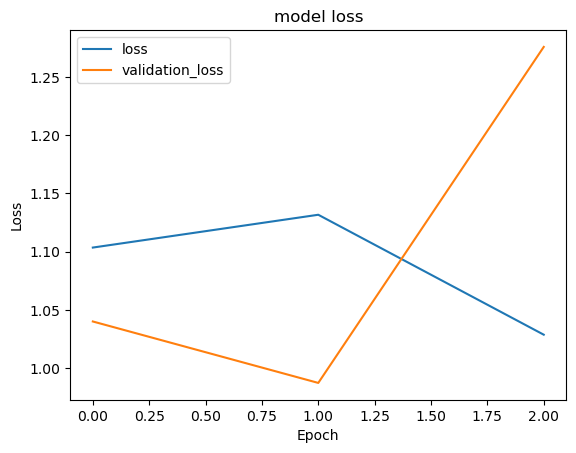

<Figure size 640x480 with 0 Axes>

In [88]:
#Plot training and validation loss for different epochs using keras loss and val_loss parameters and save the plot 
#on disk. We can also plot training and validation accuracy.

# plt.plot(hist.history["acc"])
# plt.plot(hist.history['val_acc'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss","validation_loss"])
plt.show()
plt.savefig('chart_loss.png')

## 4: Pickle the model for future prediction

In [166]:
from tensorflow.keras.models import load_model

model_resnet.save("rcnn_model")
model_resnet.save_weights("rcnn_weights.h5")

loaded_model = load_model('rcnn_model')
loaded_model.load_weights("rcnn_weights.h5")

INFO:tensorflow:Assets written to: rcnn_model\assets


INFO:tensorflow:Assets written to: rcnn_model\assets


## Lets apply the trained model on to a random test image

1/1 [==============================] - 1s 834ms/step


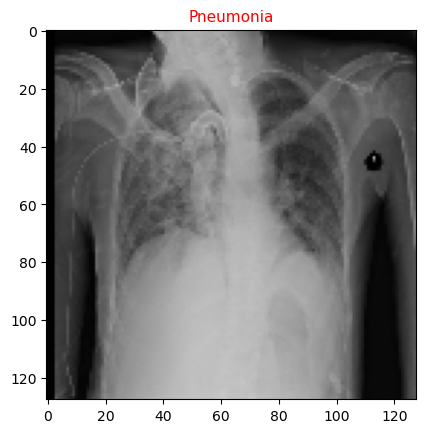

In [167]:
img = X_val[0] 
plt.imshow(img)
img = np.expand_dims(img, axis=0)

result = loaded_model.predict(img) # model loaded

#detecting positive or negative based on the loaded model
if result[0][0] > result[0][1]:
    plt.title("Pneumonia", color='red', fontsize=11)
else:
    plt.title("Normal", color='blue', fontsize=11)

1/1 [==============================] - 0s 69ms/step
[[0.61983377 0.24267611 0.13749003]]
1/1 [==============================] - 0s 63ms/step
[[0.36815256 0.3476482  0.28419918]]
1/1 [==============================] - 0s 70ms/step
[[0.20180152 0.35240483 0.4457936 ]]
1/1 [==============================] - 0s 75ms/step
[[0.38984773 0.31776494 0.29238725]]
1/1 [==============================] - 0s 70ms/step
[[0.13482389 0.2705757  0.5946004 ]]
1/1 [==============================] - 0s 66ms/step
[[0.13667394 0.29486534 0.56846064]]
1/1 [==============================] - 0s 68ms/step
[[0.6271963  0.20411928 0.16868441]]
1/1 [==============================] - 0s 69ms/step
[[0.46219188 0.28486392 0.25294423]]
1/1 [==============================] - 0s 66ms/step
[[0.15578952 0.30699575 0.53721476]]
1/1 [==============================] - 0s 71ms/step
[[0.2837434  0.2246634  0.49159312]]
1/1 [==============================] - 0s 75ms/step
[[0.15841779 0.27779707 0.56378514]]
1/1 [================

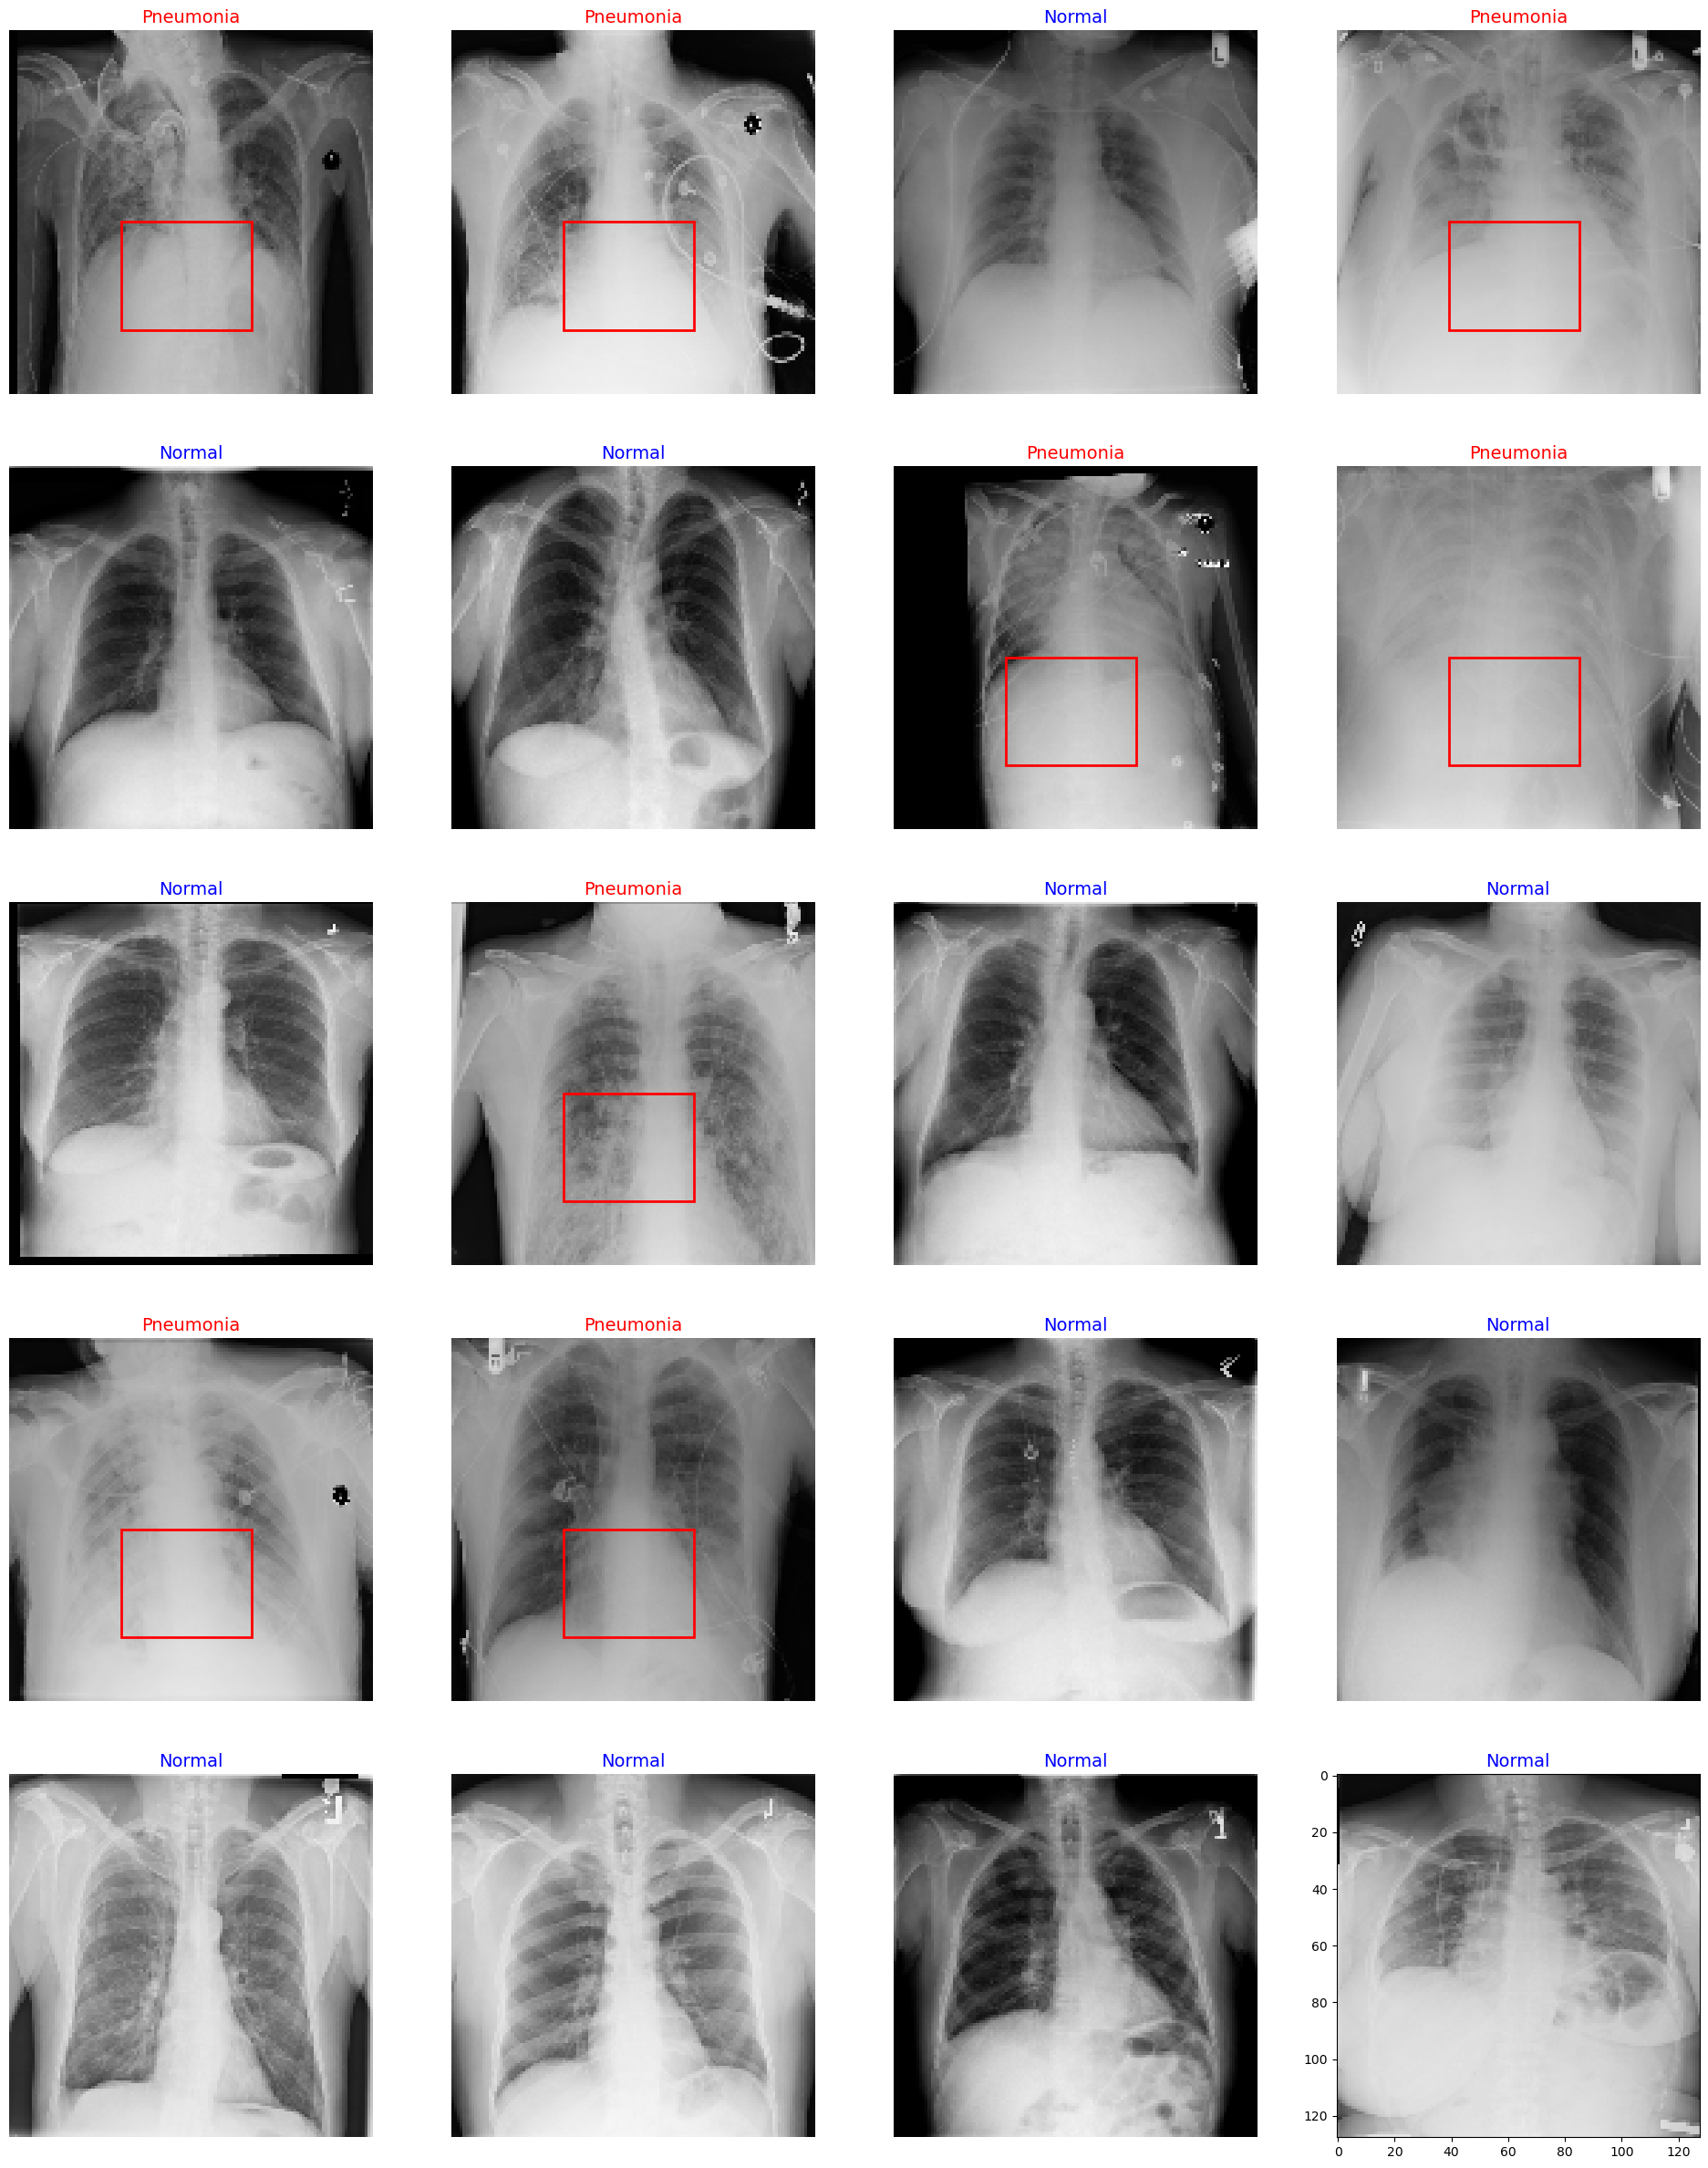

In [183]:
plt.figure(figsize=(24,30)) #
i = 0
k2 = 1

#predicting the detection on 1st 20 values of validation dataset(X_val) from loaded pickle
for i, image in enumerate(X_val):
    plt.subplot(5,4,k2)
    plt.imshow(image, cmap='gray')
    image = np.expand_dims(image, axis=0)
    result = loaded_model.predict(image) # Make predictions using the model
    print(result)
    
    # Assuming predictions include class scores and bounding box coordinates
    class_score = result[0][0].tolist()  # Adjust this based on your model's output
    bbox_coords = result[0][1].tolist()  # Adjust this based on your model's output
    
    if result[0][0] > result[0][1]:
        
        # Define your bounding box coordinates here (top-left and bottom-right)
        bbox_top_left = (39, 67)  # Example values, adjust as needed
        bbox_bottom_right = (85, 105)  # Example values, adjust as needed
        
        # Draw bounding box
        rect = plt.Rectangle(
            (bbox_top_left[0], bbox_top_left[1]),
            bbox_bottom_right[0] - bbox_top_left[0],
            bbox_bottom_right[1] - bbox_top_left[1],
            fill=False,
            color='red',
            linewidth=2
        )
        plt.gca().add_patch(rect)
        plt.title("Pneumonia", color='red', fontsize=14)
    else:
        plt.title("Normal", color='blue', fontsize=14)
    
    k2 += 1
    
    #loop to break if 20 images are judged
    if k2 >= 20:
        break
    plt.axis('off')
plt.show()